In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

In [2]:

np.random.seed(0)


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

**Loading Data**

In [4]:

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                transforms.Grayscale(),
                                ])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=transform)
train_subset, val_subset = torch.utils.data.random_split(trainset, [40000, 10000], generator=torch.Generator().manual_seed(1))
testset = torchvision.datasets.CIFAR10(root='./data', train=False,download=True, transform=transform)


classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [5]:
def load(batch_size) :
  trainloader = torch.utils.data.DataLoader(dataset=train_subset, batch_size=batch_size, shuffle=True, num_workers=2)
  valloader = torch.utils.data.DataLoader(dataset=val_subset, batch_size=batch_size, shuffle=False, num_workers=2)
  testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,shuffle=False, num_workers=2)
  return trainloader, valloader, testloader

In [6]:
def train(criterion,optimizer,trainloader,valloader,model,epochs):
  

  train_losses = []
  val_losses = []
  train_acc = []
  val_acc  = []

  for i in range(epochs):
    
      trn_corr = 0
      val_corr = 0
      batch_corr = 0
      val_batch_corr = 0
      loss_sum_train =0
      loss_sum_val =0
      

      for b_iter,data in enumerate(trainloader):
        b_iter +=1
        inputs , labels = data
        labels = labels.to(device)
        inputs = inputs.reshape(-1, 32*32*1).to(device)
        y_pred = model(inputs).to(device)
        loss = criterion(y_pred,labels.to(device))

        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == labels).sum()
        trn_corr += batch_corr.item()
        loss_sum_train += loss.item()
        
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        
      accuracy_train = trn_corr *100 / (len(trainloader.dataset))
      train_losses.append(loss_sum_train/b_iter)
      train_acc.append(accuracy_train)
      

      with torch.no_grad():
        b_iter = 0
        for b_iter,data in enumerate(valloader):
          b_iter +=1
          inputs , label = data
          label = label.to(device)
          input = inputs.reshape(-1, 32*32*1).to(device)
          y_val = model(input).to(device)

          predicted = torch.max(y_val.data, 1)[1]
          val_batch_corr = (predicted == label).sum()
          val_corr += val_batch_corr.item()
          loss_v = criterion(y_val,label.to(device))
          loss_sum_val += loss_v.item()
          
        accuracy_v = val_corr*100 / (len(valloader.dataset))
        val_losses.append(loss_sum_val/b_iter)
        val_acc.append(accuracy_v)

        print('epoch: {} , loss_train: {} , accuracy_train: {} , loss_val: {}, accuracy_validation: {} '
        .format(i,loss_sum_train/b_iter,accuracy_train,loss_sum_val/b_iter,accuracy_v))

  return train_losses, train_acc, val_losses, val_acc

In [7]:
def load_optimize_train(model,loss_function,optimizerr,epochs,batch_size):
  
  trainloader, valloader, testloader = load(batch_size)
  criterion = loss_function
  optimizer = optimizerr
  train_losses, train_acc, val_losses, val_acc = train(criterion,optimizer,trainloader,valloader,model,epochs)
  return testloader,criterion,train_losses, train_acc, val_losses, val_acc

In [8]:
def plot(x, y, x_label, y_label, t):
  plt.plot(x,label=x_label)
  plt.plot(y,label=y_label)
  plt.legend()
  plt.title(t)
  plt.show()


In [9]:
from sklearn.metrics import recall_score, accuracy_score ,precision_score,f1_score,confusion_matrix
def test(testloader,criterion,model):

  with torch.no_grad():
    test_corr = 0
    b_iter = 0
    loss_sum_test = 0
    orginal_labels = []
    predicted_labels = []

    for b_iter,data in enumerate(testloader):
      b_iter +=1
      inputs , labels = data
      labels = labels.to(device)
      orginal_labels.extend(labels.tolist())
      inputs = inputs.reshape(-1, 32*32*1).to(device)
      y_test = model(inputs).to(device)
      predicted = torch.max(y_test.data, 1)[1]
      predicted_labels.extend(predicted.tolist())
      loss_test= criterion(y_test,labels)
      loss_sum_test += loss_test.item()
      
  accuracy_test = accuracy_score(orginal_labels, predicted_labels)*100
  recall = recall_score(orginal_labels, predicted_labels,average='micro')*100
  precision = precision_score(orginal_labels, predicted_labels,average='macro')*100
  f1_s = f1_score(orginal_labels, predicted_labels,average='weighted')*100
  confusion_m = confusion_matrix(orginal_labels, predicted_labels)

  print('accuracy: {},recall : {} ,precision : {}, f1_score : {}, loss_test : {},\n confusion_matrix :\n {}  '
  .format(accuracy_test, recall, precision, f1_s,loss_sum_test/b_iter,confusion_m))

In [10]:
def epochs_plots_test (epochs,batch_size,loss_function,optimizer ):
  testloader,criterion,train_losses, train_acc, val_losses, val_acc = load_optimize_train(model,loss_function,optimizer,epochs,batch_size)
  plot(train_losses,val_losses,"train", 'validation','loss' )
  plot(train_acc,val_acc,"train", 'validation','accuracy' )
  test(testloader,criterion,model)


# ت

In [11]:
class MLP(nn.Module):

    def __init__(self, input_size=32*32*1, output_size=10 ):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 16)
        self.fc2 = nn.Linear(16, 16)
        self.fc3 = nn.Linear(16, 16)
        self.fc4 = nn.Linear(16, 16)
        self.fc5 = nn.Linear(16, 16)
        self.fc6 = nn.Linear(16, output_size)

    def forward(self, X):
      
        
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = F.relu(self.fc3(X))
        X = F.relu(self.fc4(X))
        X = F.relu(self.fc5(X))
        X = self.fc6(X)

        return X

epoch: 0 , loss_train: 9.010240366664558 , accuracy_train: 13.3575 , loss_val: 2.1745802735368285, accuracy_validation: 19.67 
epoch: 1 , loss_train: 8.457951715579048 , accuracy_train: 22.315 , loss_val: 2.0789392143011853, accuracy_validation: 24.07 
epoch: 2 , loss_train: 8.19712377242006 , accuracy_train: 25.2875 , loss_val: 2.0432277849307074, accuracy_validation: 25.56 
epoch: 3 , loss_train: 8.063536754812295 , accuracy_train: 26.5275 , loss_val: 2.017253228269827, accuracy_validation: 26.7 
epoch: 4 , loss_train: 7.9645707946235 , accuracy_train: 27.655 , loss_val: 1.9959266574238055, accuracy_validation: 27.39 
epoch: 5 , loss_train: 7.884474570758807 , accuracy_train: 28.4075 , loss_val: 1.9797996008358063, accuracy_validation: 27.96 
epoch: 6 , loss_train: 7.818086270707103 , accuracy_train: 29.1425 , loss_val: 1.967316746711731, accuracy_validation: 28.75 
epoch: 7 , loss_train: 7.760030824536333 , accuracy_train: 29.69 , loss_val: 1.9547788018997485, accuracy_validation: 2

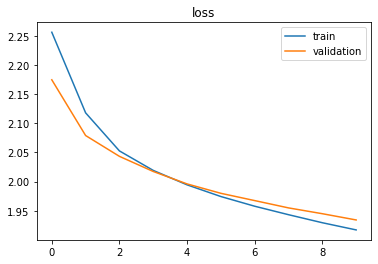

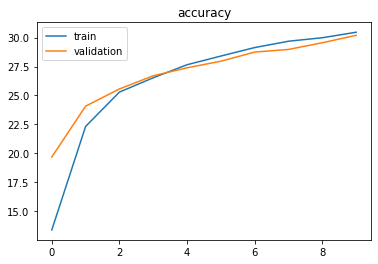

accuracy: 30.14,recall : 30.14 ,precision : 28.054717292263977, f1_score : 27.68723622342859, loss_test : 1.9230302975962337,
 confusion_matrix :
 [[277  61 154  10   0  56  87  78 209  68]
 [ 33 400  24   7   0  26 101  35 131 243]
 [122  40 297  21   2 120 206 118  49  25]
 [ 71  52 114  56   3 264 186 145  62  47]
 [ 65  55 205  17   2 119 278 175  46  38]
 [ 77  27 105  47   3 373 138 123  76  31]
 [ 43  79  96  52   4 149 353 141  30  53]
 [ 75  40 116  30   2  77 152 347  60 101]
 [102 103  43   8   0  83  42  28 488 103]
 [ 44 212  14  17   0  15  76  46 155 421]]  


In [12]:
epochs = 10
batch_size =32
model = MLP()
model.to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
epochs_plots_test (epochs,batch_size,loss_function,optimizer )

In [13]:
class MLP(nn.Module):

    def __init__(self, input_size=32*32*1, output_size=10 ):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 16)
        self.fc2 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(8, 8)
        self.fc4 = nn.Linear(8, 8)
        self.fc5 = nn.Linear(8, 16)
        self.fc6 = nn.Linear(16, output_size)

    def forward(self, X):
      
        
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = F.relu(self.fc3(X))
        X = F.relu(self.fc4(X))
        X = F.relu(self.fc5(X))
        X = self.fc6(X)

        return X

epoch: 0 , loss_train: 9.11758190602921 , accuracy_train: 11.685 , loss_val: 2.2367082525746893, accuracy_validation: 16.1 
epoch: 1 , loss_train: 8.636366643844703 , accuracy_train: 16.7925 , loss_val: 2.122723868479744, accuracy_validation: 17.82 
epoch: 2 , loss_train: 8.39041030483124 , accuracy_train: 18.4175 , loss_val: 2.092665304391148, accuracy_validation: 18.52 
epoch: 3 , loss_train: 8.293014645576477 , accuracy_train: 19.44 , loss_val: 2.076179790039794, accuracy_validation: 19.73 
epoch: 4 , loss_train: 8.226630201735816 , accuracy_train: 20.75 , loss_val: 2.064991427686649, accuracy_validation: 21.2 
epoch: 5 , loss_train: 8.168117549091864 , accuracy_train: 21.845 , loss_val: 2.055794331974115, accuracy_validation: 21.52 
epoch: 6 , loss_train: 8.115159854340478 , accuracy_train: 22.4675 , loss_val: 2.044435978697512, accuracy_validation: 22.86 
epoch: 7 , loss_train: 8.055213512704015 , accuracy_train: 23.54 , loss_val: 2.031655596848875, accuracy_validation: 23.4 
epoc

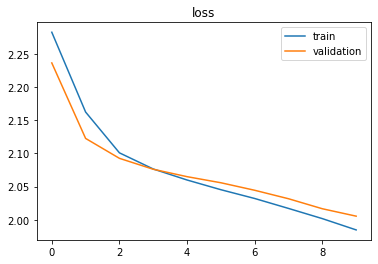

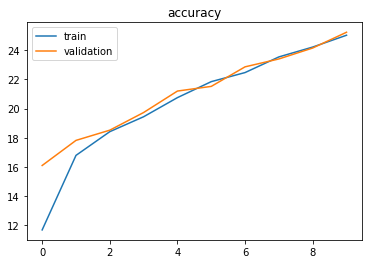

accuracy: 24.77,recall : 24.77 ,precision : 22.85299498318955, f1_score : 21.18896613508477, loss_test : 1.9946642729421011,
 confusion_matrix :
 [[325 157 174   3  35  97  48  11 103  47]
 [ 89 453  23   2  23  60  40  10  76 224]
 [155  41 371   2  67 258  57   9  24  16]
 [124  63 152   5  48 461  52  18  35  42]
 [111  36 292   3  79 320  70  12  56  21]
 [ 79  29 159   6  45 554  52  12  39  25]
 [153  53 169  13  67 334 116  13  45  37]
 [ 79  57 143   1  39 496  38  21  67  59]
 [135 335  46   6  42 103  20  10 178 125]
 [ 82 315  25   3  28  52  19  14  87 375]]  


In [14]:
epochs = 10
batch_size =32
model = MLP()
model.to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
epochs_plots_test (epochs,batch_size,loss_function,optimizer )

In [15]:
class MLP(nn.Module):

    def __init__(self, input_size=32*32*1, output_size=10 ):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 16)
        self.fc2 = nn.Linear(16, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 64)
        self.fc5 = nn.Linear(64, 16)
        self.fc6 = nn.Linear(16, output_size)

    def forward(self, X):
      
        
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = F.relu(self.fc3(X))
        X = F.relu(self.fc4(X))
        X = F.relu(self.fc5(X))
        X = self.fc6(X)

        return X

epoch: 0 , loss_train: 8.72209431035831 , accuracy_train: 18.54 , loss_val: 2.0725968451545644, accuracy_validation: 22.99 
epoch: 1 , loss_train: 8.09473014220643 , accuracy_train: 25.9525 , loss_val: 1.9920580687995155, accuracy_validation: 28.22 
epoch: 2 , loss_train: 7.843264831140781 , accuracy_train: 29.32 , loss_val: 1.9420565755222552, accuracy_validation: 30.43 
epoch: 3 , loss_train: 7.658112054815688 , accuracy_train: 31.125 , loss_val: 1.9104372388638629, accuracy_validation: 31.48 
epoch: 4 , loss_train: 7.524922641702354 , accuracy_train: 32.215 , loss_val: 1.888127636985657, accuracy_validation: 32.14 
epoch: 5 , loss_train: 7.434499943980013 , accuracy_train: 32.7425 , loss_val: 1.871325013355706, accuracy_validation: 32.51 
epoch: 6 , loss_train: 7.3639542344279185 , accuracy_train: 33.5525 , loss_val: 1.8605335215790966, accuracy_validation: 32.74 
epoch: 7 , loss_train: 7.305893122578581 , accuracy_train: 34.1125 , loss_val: 1.8529345227506595, accuracy_validation: 

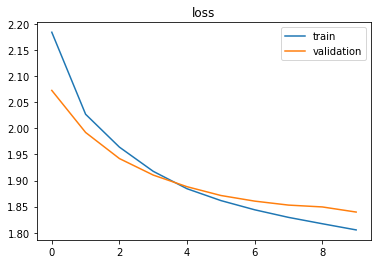

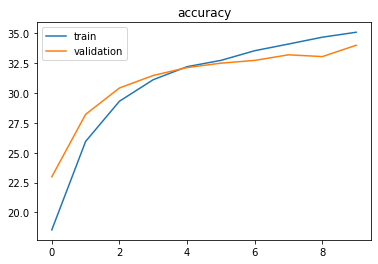

accuracy: 34.870000000000005,recall : 34.870000000000005 ,precision : 34.78833496374353, f1_score : 34.2524113967139, loss_test : 1.825033500171698,
 confusion_matrix :
 [[262  53 149  24  82  25  98  76 183  48]
 [ 27 430  10  18  37  20  98  30 129 201]
 [ 52  28 309  77 118  69 202  87  33  25]
 [ 51  38  82 131  86 206 203  94  42  67]
 [ 37  45 196  33 249  56 183 127  43  31]
 [ 30  20 102  98  86 346 135  96  58  29]
 [ 28  48  87  63 106  91 482  23  26  46]
 [ 42  42  81  39 118  76  80 399  59  64]
 [ 83  94  44  22  33  68  40  55 458 103]
 [ 23 206  16  35  22  15  82  59 121 421]]  


In [16]:
epochs = 10
batch_size =32
model = MLP()
model.to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
epochs_plots_test (epochs,batch_size,loss_function,optimizer )

# د

In [17]:
class MLP(nn.Module):

    def __init__(self, input_size=32*32*1, output_size=10 ):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 16)
        self.fc2 = nn.Linear(16, 16)
        self.fc3 = nn.Linear(16, 16)
        self.fc4 = nn.Linear(16, 16)
        self.fc5 = nn.Linear(16, 16)
        self.fc6 = nn.Linear(16, output_size)

    def forward(self, X):
      
        
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = F.relu(self.fc3(X))
        X = F.relu(self.fc4(X))
        X = F.relu(self.fc5(X))
        X = self.fc6(X)

        return X

In [11]:
def train_2(criterion,optimizer,trainloader,valloader,model,epochs):
  

  train_losses = []
  train_acc = []

  for i in range(epochs):
    
      trn_corr = 0
      batch_corr = 0
      loss_sum_train =0
      
      

      for b_iter,data in enumerate(trainloader):
        b_iter +=1
        inputs , labels = data
        labels = labels.to(device)
        inputs = inputs.reshape(-1, 32*32*1).to(device)
        y_pred = model(inputs).to(device)
        loss = criterion(y_pred,labels)

        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == labels).sum()
        trn_corr += batch_corr.item()
        loss_sum_train += loss.item()
        
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        
      accuracy_train = trn_corr *100 / (len(trainloader.dataset))
      train_losses.append(loss_sum_train/b_iter)
      train_acc.append(accuracy_train)
      

  return train_losses, train_acc


 batch_size: 32 
, time: 218.4835867881775 ,loss: 1.9277446935653686 , accuracy : 29.72  
epoch: 0 , loss_train: 7.65006301159295 , accuracy_train: 30.3 , loss_val: 1.9304115018143821, accuracy_validation: 29.89 
epoch: 1 , loss_train: 7.599920943522225 , accuracy_train: 30.7325 , loss_val: 1.9169338918722476, accuracy_validation: 30.32 
epoch: 2 , loss_train: 7.549130626379872 , accuracy_train: 31.2925 , loss_val: 1.9074344330321487, accuracy_validation: 30.82 
epoch: 3 , loss_train: 7.497771243698681 , accuracy_train: 31.7925 , loss_val: 1.8989339297571883, accuracy_validation: 31.37 
epoch: 4 , loss_train: 7.450097256575149 , accuracy_train: 32.28 , loss_val: 1.889098161325668, accuracy_validation: 31.71 
epoch: 5 , loss_train: 7.406974903691691 , accuracy_train: 32.74 , loss_val: 1.8802429357656656, accuracy_validation: 31.96 
epoch: 6 , loss_train: 7.367373996268446 , accuracy_train: 33.1525 , loss_val: 1.8728787190617082, accuracy_validation: 32.35 
epoch: 7 , loss_train: 7.3300

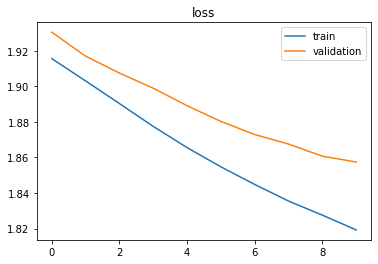

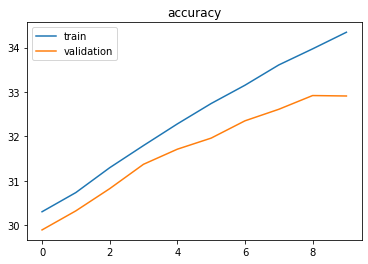

accuracy: 32.95,recall : 32.95 ,precision : 31.57262702014099, f1_score : 31.496486002965636, loss_test : 1.8433336872643176,
 confusion_matrix :
 [[309  45 103  14  87  24  66  56 255  41]
 [ 28 377   5  10  20  19 100  34 154 253]
 [125  26 219  35 146 110 164  99  44  32]
 [ 73  37  67  38  73 235 170 165  57  85]
 [ 81  32 146   5 223  85 226 104  68  30]
 [ 52   8 101  44  65 358 118 127  77  50]
 [ 55  55  72  45 143  89 359  80  49  53]
 [ 53  38  64  26  78  96 113 378  68  86]
 [ 98  74  14  10  35  46  37  31 559  96]
 [ 27 161   6  14  12  21  63  75 146 475]]  

 batch_size: 64 
, time: 174.95160341262817 ,loss: 1.9707949880599975 , accuracy : 25.9425  
epoch: 0 , loss_train: 7.805281841071548 , accuracy_train: 26.6075 , loss_val: 1.9767343139952156, accuracy_validation: 25.98 
epoch: 1 , loss_train: 7.771355462681716 , accuracy_train: 27.07 , loss_val: 1.9680169585404124, accuracy_validation: 26.16 
epoch: 2 , loss_train: 7.736659317259576 , accuracy_train: 27.47 , loss_va

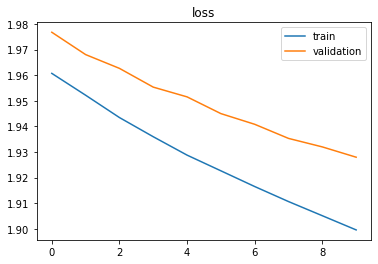

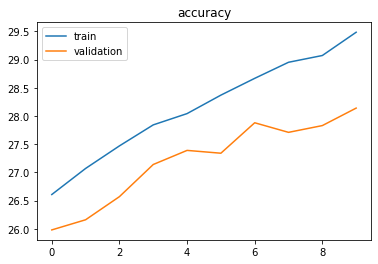

accuracy: 28.89,recall : 28.89 ,precision : 27.990298560041964, f1_score : 27.423268088504628, loss_test : 1.9248340403198436,
 confusion_matrix :
 [[385  79 118  17 110  26  42  40 135  48]
 [ 43 499  11  15  33  15  94  15 106 169]
 [113  48 240  44 204  81 194  32  30  14]
 [ 62  90  93  97 118 226 189  33  70  22]
 [ 95  64 183  22 327  56 178  33  30  12]
 [ 69  40 112  71 103 319 156  32  92   6]
 [ 42  91  97  48 182 124 336  29  35  16]
 [140  87 135  63 195  72 128  50  97  33]
 [191 117  34  18  26  59  28  28 362 137]
 [ 58 389   8  19  27  14  69  10 132 274]]  

 batch_size: 128 
, time: 151.29052925109863 ,loss: 2.0032510544164492 , accuracy : 26.7475  
epoch: 0 , loss_train: 7.876780973205084 , accuracy_train: 27.3525 , loss_val: 1.9914329127420354, accuracy_validation: 27.38 
epoch: 1 , loss_train: 7.824045407621166 , accuracy_train: 27.86 , loss_val: 1.9815479743329785, accuracy_validation: 27.95 
epoch: 2 , loss_train: 7.776754545260079 , accuracy_train: 28.4175 , los

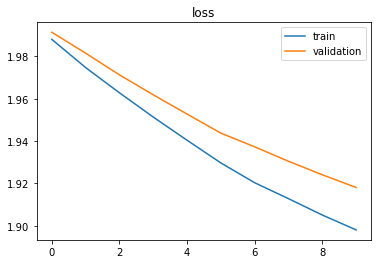

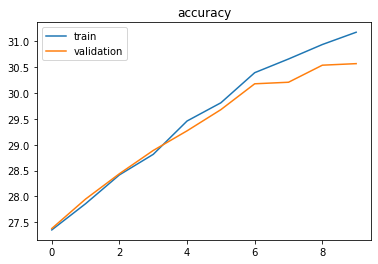

accuracy: 31.330000000000002,recall : 31.330000000000002 ,precision : 30.347364932555713, f1_score : 28.669507704487202, loss_test : 1.9055578889726084,
 confusion_matrix :
 [[279  75 106   3  19  90  83 100 201  44]
 [ 28 445   8   1   6  23 119  44 148 178]
 [ 91  55 227   6  37 165 232 134  35  18]
 [ 61  68 101  15  25 237 243 146  63  41]
 [ 57  65 106   6  53 172 246 215  56  24]
 [ 59  34 109  19  20 364 176 133  70  16]
 [ 30 111  52   8  29 172 465  60  38  35]
 [ 64  61  76  10  26  84 105 443  60  71]
 [105 126  14   2   3  82  40  62 485  81]
 [ 29 253  15   1   3  19  94  76 153 357]]  

 batch_size: 512 
, time: 134.2068555355072 ,loss: 2.0666711451132085 , accuracy : 24.155  
epoch: 0 , loss_train: 8.102763545513152 , accuracy_train: 25.0025 , loss_val: 2.0465563595294953, accuracy_validation: 25.38 
epoch: 1 , loss_train: 8.050434988737106 , accuracy_train: 25.755 , loss_val: 2.0353494763374327, accuracy_validation: 25.8 
epoch: 2 , loss_train: 8.004327499866486 , accur

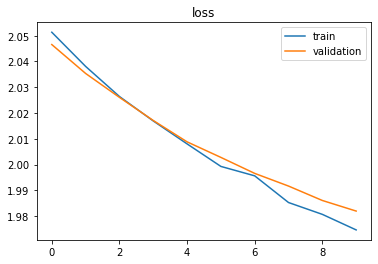

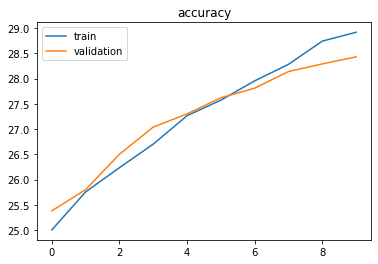

accuracy: 28.48,recall : 28.48 ,precision : 27.291121405364837, f1_score : 26.446988940120775, loss_test : 1.9781981468200684,
 confusion_matrix :
 [[288  88 128   1  52  82  38  66 187  70]
 [ 24 436  17   0  36  33  53  40 117 244]
 [140  60 214   7  67 231 100 104  49  28]
 [ 72  69  72   7 104 325  66 156  61  68]
 [ 65  84 164   4 201 182  98  97  60  45]
 [ 81  26  91   6  93 435  41 113  74  40]
 [ 50 122  98   3  99 226 156 122  40  84]
 [ 89  68  72   4 118 206  34 240  79  90]
 [ 89 140  30   3  40  79  18  35 449 117]
 [ 25 231  12   1  15  23  51  76 144 422]]  


In [19]:
import time
for i in [32,64,128,512]:
  epochs = 10
  batch_size = i
  model = MLP()
  model.to(device)
  loss_function = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=0.0001)
  trainloader, valloader, testloader = load(batch_size)
  criterion = loss_function
  start = time.time()
  train_losses, train_acc =train_2(criterion,optimizer,trainloader,valloader,model,epochs)
  end = time.time()
  t= end-start
  
  print('\n batch_size: {} \n, time: {} ,loss: {} , accuracy : {}  '.format(batch_size,t,train_losses[9], train_acc[9]))
  epochs_plots_test (epochs,batch_size,loss_function,optimizer )

#ه

In [12]:
def loss_acc_time_of_train ():
  epochs = 10
  batch_size = 128
  model = MLP()
  model.to(device)
  loss_function = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=0.0001)
  trainloader, valloader, testloader = load(batch_size)
  criterion = loss_function
  start = time.time()
  train_losses, train_acc =train_2(criterion,optimizer,trainloader,valloader,model,epochs)
  end = time.time()
  t= end-start
  print(' time: {} ,loss: {} , accuracy : {}  '.format(t,train_losses[9], train_acc[9]))
  

In [21]:
class MLP(nn.Module):

    def __init__(self, input_size=32*32*1, output_size=10 ):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 16)
        self.fc2 = nn.Linear(16, 16)
        self.fc3 = nn.Linear(16, 16)
        self.fc4 = nn.Linear(16, 16)
        self.fc5 = nn.Linear(16, 16)
        self.fc6 = nn.Linear(16, output_size)

    def forward(self, X):
      
        
        X = torch.sigmoid(self.fc1(X))
        X = torch.sigmoid(self.fc2(X))
        X = torch.sigmoid(self.fc3(X))
        X = torch.sigmoid(self.fc4(X))
        X = torch.sigmoid(self.fc5(X))
        X = self.fc6(X)

        return X

epoch: 0 , loss_train: 9.328319084644317 , accuracy_train: 10.03 , loss_val: 2.3591251730918885, accuracy_validation: 9.88 
epoch: 1 , loss_train: 9.268130052089692 , accuracy_train: 10.03 , loss_val: 2.345346820354462, accuracy_validation: 9.88 
epoch: 2 , loss_train: 9.225853610038758 , accuracy_train: 10.03 , loss_val: 2.335061287879944, accuracy_validation: 9.88 
epoch: 3 , loss_train: 9.191392064094543 , accuracy_train: 10.03 , loss_val: 2.3272058010101317, accuracy_validation: 9.88 
epoch: 4 , loss_train: 9.16752403974533 , accuracy_train: 10.03 , loss_val: 2.321170473098755, accuracy_validation: 9.88 
epoch: 5 , loss_train: 9.146704840660096 , accuracy_train: 10.03 , loss_val: 2.3164767980575562, accuracy_validation: 9.88 
epoch: 6 , loss_train: 9.13213382959366 , accuracy_train: 10.03 , loss_val: 2.3129263520240784, accuracy_validation: 9.88 
epoch: 7 , loss_train: 9.121678340435029 , accuracy_train: 10.03 , loss_val: 2.31019012928009, accuracy_validation: 9.88 
epoch: 8 , loss

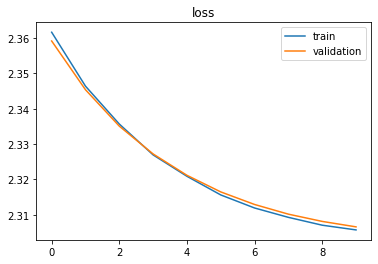

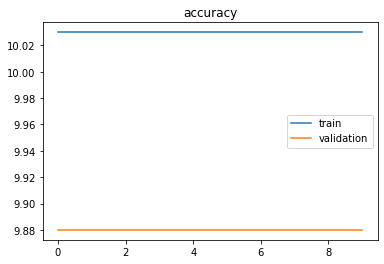

accuracy: 10.0,recall : 10.0 ,precision : 1.0, f1_score : 1.8181818181818181, loss_test : 2.305305850505829,
 confusion_matrix :
 [[   0 1000    0    0    0    0    0    0    0    0]
 [   0 1000    0    0    0    0    0    0    0    0]
 [   0 1000    0    0    0    0    0    0    0    0]
 [   0 1000    0    0    0    0    0    0    0    0]
 [   0 1000    0    0    0    0    0    0    0    0]
 [   0 1000    0    0    0    0    0    0    0    0]
 [   0 1000    0    0    0    0    0    0    0    0]
 [   0 1000    0    0    0    0    0    0    0    0]
 [   0 1000    0    0    0    0    0    0    0    0]
 [   0 1000    0    0    0    0    0    0    0    0]]  


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [22]:
#sigmoid
epochs = 10
batch_size =128
model = MLP()
model.to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
epochs_plots_test (epochs,batch_size,loss_function,optimizer )

In [23]:
class MLP(nn.Module):

    def __init__(self, input_size=32*32*1, output_size=10 ):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 16)
        self.fc2 = nn.Linear(16, 16)
        self.fc3 = nn.Linear(16, 16)
        self.fc4 = nn.Linear(16, 16)
        self.fc5 = nn.Linear(16, 16)
        self.fc6 = nn.Linear(16, output_size)

    def forward(self, X):
      
        
        X = torch.tanh(self.fc1(X))
        X = torch.tanh(self.fc2(X))
        X = torch.tanh(self.fc3(X))
        X = torch.tanh(self.fc4(X))
        X = torch.tanh(self.fc5(X))
        X = self.fc6(X)

        return X

epoch: 0 , loss_train: 9.078256750106812 , accuracy_train: 9.3525 , loss_val: 2.2834738969802855, accuracy_validation: 9.71 
epoch: 1 , loss_train: 8.973674380779267 , accuracy_train: 11.51 , loss_val: 2.2570980072021483, accuracy_validation: 16.64 
epoch: 2 , loss_train: 8.860152661800385 , accuracy_train: 18.8625 , loss_val: 2.2259711980819703, accuracy_validation: 19.99 
epoch: 3 , loss_train: 8.73363151550293 , accuracy_train: 20.725 , loss_val: 2.1937875270843508, accuracy_validation: 21.45 
epoch: 4 , loss_train: 8.604980635643006 , accuracy_train: 22.1 , loss_val: 2.1650896787643434, accuracy_validation: 22.2 
epoch: 5 , loss_train: 8.496362900733947 , accuracy_train: 22.815 , loss_val: 2.140309381484985, accuracy_validation: 22.77 
epoch: 6 , loss_train: 8.401996910572052 , accuracy_train: 23.495 , loss_val: 2.1208136320114135, accuracy_validation: 23.76 
epoch: 7 , loss_train: 8.32327481508255 , accuracy_train: 24.3475 , loss_val: 2.1049889087677003, accuracy_validation: 24.21

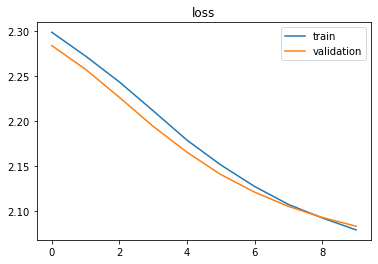

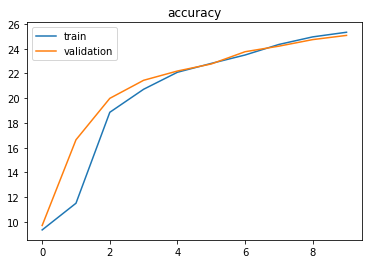

accuracy: 25.31,recall : 25.31 ,precision : 22.990770250163806, f1_score : 22.37338603497409, loss_test : 2.0808815717697144,
 confusion_matrix :
 [[249  40  17   2  29 118  79 153 204 109]
 [ 28 245   8   2  22  45 163  42  86 359]
 [210  57  30   1  45 148 192 207  67  43]
 [ 76  74  23   1  68 243 193 171  77  74]
 [ 91  58  19   1 119 154 225 219  62  52]
 [ 86  50  32   0  49 357 135 149 110  32]
 [ 51 134  22   1  43 168 360  82  57  82]
 [122  38  23   0  91 109 115 294 102 106]
 [118  42   6   1   9 142  56  29 368 229]
 [ 36 184  17   0   8  29  80  31 107 508]]  


In [24]:
# tanh
epochs = 10
batch_size =128
model = MLP()
model.to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
epochs_plots_test (epochs,batch_size,loss_function,optimizer )

#ج

In [15]:
class MLP(nn.Module):

    def __init__(self, input_size=32*32*1, output_size=10 ):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 16)
        self.fc2 = nn.Linear(16, 16)
        self.fc3 = nn.Linear(16, 16)
        self.fc4 = nn.Linear(16, 16)
        self.fc5 = nn.Linear(16, 16)
        self.fc6 = nn.Linear(16, output_size)

    def forward(self, X):
      
        
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = F.relu(self.fc3(X))
        X = F.relu(self.fc4(X))
        X = F.relu(self.fc5(X))
        X = self.fc6(X)

        return X

epoch: 0 , loss_train: 9.169664422168008 , accuracy_train: 10.1 , loss_val: 2.313187550894822, accuracy_validation: 9.6 
epoch: 1 , loss_train: 9.141518408739113 , accuracy_train: 10.1 , loss_val: 2.3075757509545434, accuracy_validation: 9.6 
epoch: 2 , loss_train: 9.128217072426517 , accuracy_train: 10.1 , loss_val: 2.3043518126765385, accuracy_validation: 9.6 
epoch: 3 , loss_train: 9.119467569302909 , accuracy_train: 10.1 , loss_val: 2.30192588552644, accuracy_validation: 9.68 
epoch: 4 , loss_train: 9.111970952794522 , accuracy_train: 11.025 , loss_val: 2.299650819995735, accuracy_validation: 12.04 
epoch: 5 , loss_train: 9.10194896142694 , accuracy_train: 14.015 , loss_val: 2.296134541306315, accuracy_validation: 13.74 
epoch: 6 , loss_train: 9.080446083334428 , accuracy_train: 14.7675 , loss_val: 2.287351988538911, accuracy_validation: 13.97 
epoch: 7 , loss_train: 9.017293631275997 , accuracy_train: 14.6675 , loss_val: 2.2626775880403156, accuracy_validation: 14.0 
epoch: 8 , lo

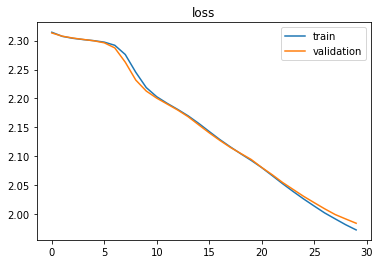

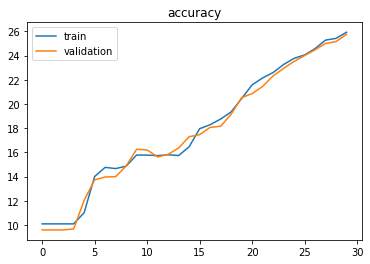

accuracy: 25.56,recall : 25.56 ,precision : 23.966178871147346, f1_score : 22.23047066077067, loss_test : 1.9824416350714769,
 confusion_matrix :
 [[318  59  22   2   6 194  64  73 209  53]
 [ 53 361   8   0   2  19  90  49 134 284]
 [146  41  45   3   8 423 203  77  23  31]
 [126  48  31   4  10 327 240 109  32  73]
 [124  66  42   6  13 309 289  93  32  26]
 [151  20  29   5   8 446 185  87  41  28]
 [ 72  56  48   6   9 252 360 118  20  59]
 [135  49  48   0   7 282 164 165  46 104]
 [237 103  15   4   1  72  36  40 377 115]
 [ 49 163   8   0   3  20  58  74 158 467]]  


In [16]:
# sgd
epochs = 30
batch_size =128
model = MLP()
model.to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
epochs_plots_test (epochs,batch_size,loss_function,optimizer )

epoch: 0 , loss_train: 8.201086027712762 , accuracy_train: 23.985 , loss_val: 1.9822073269493972, accuracy_validation: 27.36 
epoch: 1 , loss_train: 7.733235104174554 , accuracy_train: 28.97 , loss_val: 1.9397853069667574, accuracy_validation: 29.51 
epoch: 2 , loss_train: 7.5730120909364915 , accuracy_train: 30.78 , loss_val: 1.9143605518944655, accuracy_validation: 30.42 
epoch: 3 , loss_train: 7.470785349230223 , accuracy_train: 31.7625 , loss_val: 1.8979177550424504, accuracy_validation: 31.34 
epoch: 4 , loss_train: 7.395815290982211 , accuracy_train: 32.225 , loss_val: 1.8852787244169018, accuracy_validation: 31.96 
epoch: 5 , loss_train: 7.337126399897322 , accuracy_train: 32.855 , loss_val: 1.8745534963245634, accuracy_validation: 31.95 
epoch: 6 , loss_train: 7.291389261619954 , accuracy_train: 33.3125 , loss_val: 1.8637871365003948, accuracy_validation: 32.75 
epoch: 7 , loss_train: 7.2537130615379235 , accuracy_train: 33.7 , loss_val: 1.8616814236097698, accuracy_validation:

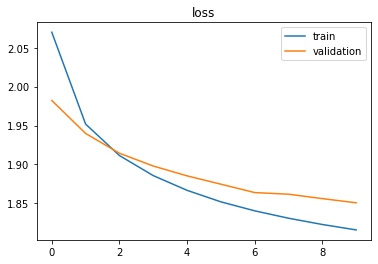

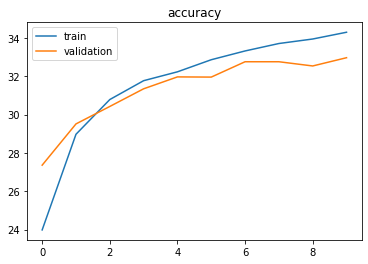

accuracy: 33.56,recall : 33.56 ,precision : 33.33457271981676, f1_score : 32.894513638932914, loss_test : 1.8396149028705646,
 confusion_matrix :
 [[315  52 131  16  78  17  69  83 188  51]
 [ 28 413   7  13  27   7 103  41 139 222]
 [113  40 245  28 142  71 186 114  35  26]
 [ 53  35  91 117  87 169 214 104  57  73]
 [100  45 154  25 268  52 166 124  40  26]
 [ 59  15  85 102  63 311 145 124  61  35]
 [ 42  63  83  53 134  73 419  54  28  51]
 [ 83  33  77  28  99  75  74 417  35  79]
 [146  95  35  32  28  29  37  40 455 103]
 [ 27 224  10  12  23  18  97  64 129 396]]  


In [17]:
# Adagrad
epochs = 10
batch_size =128
model = MLP()
model.to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adagrad(model.parameters(), lr=0.01, lr_decay=0, weight_decay=0, initial_accumulator_value=0, eps=1e-10)
epochs_plots_test (epochs,batch_size,loss_function,optimizer )

# ح

In [18]:
class MLP(nn.Module):

    def __init__(self, input_size=32*32*1, output_size=10 ):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 16)
        self.fc2 = nn.Linear(16, 16)
        self.fc3 = nn.Linear(16, 16)
        self.fc4 = nn.Linear(16, 16)
        self.fc5 = nn.Linear(16, 16)
        self.fc6 = nn.Linear(16, 16)
        #self.fc7 = nn.Linear(16, 16)
        self.fc7 = nn.Linear(16, output_size)

    def forward(self, X):
      
        
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = F.relu(self.fc3(X))
        X = F.relu(self.fc4(X))
        X = F.relu(self.fc5(X))
        X = F.relu(self.fc6(X))
        #X = F.relu(self.fc7(X))
        X = self.fc7(X)

        return X

epoch: 0 , loss_train: 9.129168791106984 , accuracy_train: 11.6975 , loss_val: 2.286491481563713, accuracy_validation: 16.74 
epoch: 1 , loss_train: 8.882881152478955 , accuracy_train: 17.39 , loss_val: 2.190105528771123, accuracy_validation: 19.22 
epoch: 2 , loss_train: 8.528398734104785 , accuracy_train: 20.7575 , loss_val: 2.1178188942655733, accuracy_validation: 21.81 
epoch: 3 , loss_train: 8.30180061617984 , accuracy_train: 23.195 , loss_val: 2.080083204221122, accuracy_validation: 23.02 
epoch: 4 , loss_train: 8.184534066840063 , accuracy_train: 23.7225 , loss_val: 2.0605424250228497, accuracy_validation: 23.58 
epoch: 5 , loss_train: 8.108838761909098 , accuracy_train: 24.235 , loss_val: 2.0454831138441834, accuracy_validation: 23.59 
epoch: 6 , loss_train: 8.04885723017439 , accuracy_train: 24.6175 , loss_val: 2.032151109055628, accuracy_validation: 24.16 
epoch: 7 , loss_train: 7.994719108448753 , accuracy_train: 25.34 , loss_val: 2.0203953543795814, accuracy_validation: 24.

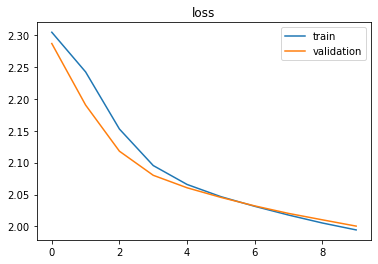

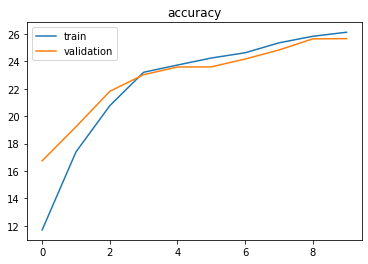

accuracy: 26.21,recall : 26.21 ,precision : 25.73304125477892, f1_score : 24.430904769835642, loss_test : 1.9947806823102734,
 confusion_matrix :
 [[184  69 193   9  16  40 104 100 217  68]
 [ 14 389   7  12   9  17 136  34 108 274]
 [106  63 219  23  21  90 235 185  34  24]
 [ 63  75  86  66  14 242 219 132  55  48]
 [ 72  62 100  26  33  93 350 185  55  24]
 [ 72  50 100  49  14 366 155 120  57  17]
 [ 41 145  46  53  14 123 383 125  23  47]
 [ 78  61 144  40  18 123 178 201  96  61]
 [110  97  26  20   3  86  56  43 388 171]
 [ 26 252  18   9   7  22  94  32 148 392]]  


In [19]:
epochs = 10
batch_size =128
model = MLP()
model.to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
epochs_plots_test (epochs,batch_size,loss_function,optimizer )

In [20]:
class MLP(nn.Module):

    def __init__(self, input_size=32*32*1, output_size=10 ):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 16)
        self.fc2 = nn.Linear(16, 16)
        self.fc3 = nn.Linear(16, 16)
        self.fc4 = nn.Linear(16, 16)
        self.fc5 = nn.Linear(16, 16)
        self.fc6 = nn.Linear(16, 16)
        self.fc7 = nn.Linear(16, 16)
        self.fc8 = nn.Linear(16, output_size)

    def forward(self, X):
      
        
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = F.relu(self.fc3(X))
        X = F.relu(self.fc4(X))
        X = F.relu(self.fc5(X))
        X = F.relu(self.fc6(X))
        X = F.relu(self.fc7(X))
        X = self.fc8(X)

        return X

epoch: 0 , loss_train: 9.163207229179672 , accuracy_train: 9.92 , loss_val: 2.30260250840006, accuracy_validation: 10.32 
epoch: 1 , loss_train: 9.024175372304796 , accuracy_train: 11.785 , loss_val: 2.2311210179630714, accuracy_validation: 15.92 
epoch: 2 , loss_train: 8.582535529438454 , accuracy_train: 18.0275 , loss_val: 2.133484665351578, accuracy_validation: 19.63 
epoch: 3 , loss_train: 8.334531658812415 , accuracy_train: 21.4475 , loss_val: 2.091778681248049, accuracy_validation: 21.28 
epoch: 4 , loss_train: 8.196876064131532 , accuracy_train: 22.9625 , loss_val: 2.0669848737837393, accuracy_validation: 22.32 
epoch: 5 , loss_train: 8.106326515161538 , accuracy_train: 23.79 , loss_val: 2.049066579794582, accuracy_validation: 23.41 
epoch: 6 , loss_train: 8.044249459158015 , accuracy_train: 24.1025 , loss_val: 2.034933960890468, accuracy_validation: 23.32 
epoch: 7 , loss_train: 7.992587430567681 , accuracy_train: 24.375 , loss_val: 2.0243462233603755, accuracy_validation: 23.6

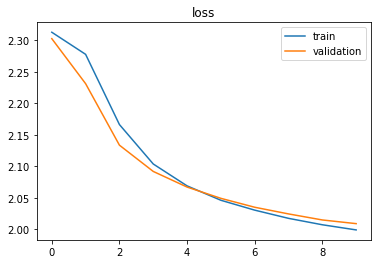

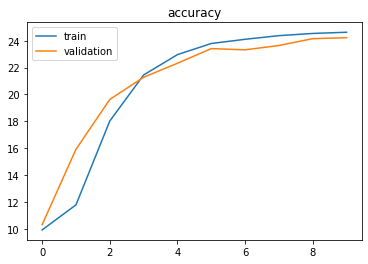

accuracy: 24.560000000000002,recall : 24.560000000000002 ,precision : 23.495714555413905, f1_score : 20.223190477628542, loss_test : 2.004041042508958,
 confusion_matrix :
 [[ 63  82  18   1 222 168  73   3 302  68]
 [ 22 458   3   0  76  23  82   8 131 197]
 [ 35  61  17   1 418 219 159  15  61  14]
 [ 36  96  11   9 308 259 152  16  80  33]
 [ 32  81  22   3 429 166 163  17  64  23]
 [ 34  39  14   7 290 360 120  11 109  16]
 [ 44 135  13   2 288 146 286  18  37  31]
 [ 59 111  11   1 452  89 106   8  92  71]
 [ 46 104   4   1  47 111  38   6 529 114]
 [ 25 360   0   0  86  19  29  14 170 297]]  


In [21]:
epochs = 10
batch_size =128
model = MLP()
model.to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
epochs_plots_test (epochs,batch_size,loss_function,optimizer )

In [22]:
class MLP(nn.Module):

    def __init__(self, input_size=32*32*1, output_size=10 ):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 16)
        self.fc2 = nn.Linear(16, 16)
        self.fc3 = nn.Linear(16, 16)
        self.fc4 = nn.Linear(16, 16)
        self.fc5 = nn.Linear(16, 16)
        self.fc6 = nn.Linear(16, 16)
        self.fc7 = nn.Linear(16, 16)
        self.fc8 = nn.Linear(16, 16)
        self.fc9 = nn.Linear(16, output_size)

    def forward(self, X):
      
        
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = F.relu(self.fc3(X))
        X = F.relu(self.fc4(X))
        X = F.relu(self.fc5(X))
        X = F.relu(self.fc6(X))
        X = F.relu(self.fc7(X))
        X = F.relu(self.fc8(X))
        X = self.fc9(X)

        return X

epoch: 0 , loss_train: 9.130054826977887 , accuracy_train: 10.6675 , loss_val: 2.269000937667074, accuracy_validation: 16.43 
epoch: 1 , loss_train: 8.818199344828159 , accuracy_train: 16.3 , loss_val: 2.202146240427524, accuracy_validation: 16.51 
epoch: 2 , loss_train: 8.63850113409984 , accuracy_train: 16.7125 , loss_val: 2.159851345834853, accuracy_validation: 16.95 
epoch: 3 , loss_train: 8.462368977220752 , accuracy_train: 17.5075 , loss_val: 2.1222141226635705, accuracy_validation: 18.88 
epoch: 4 , loss_train: 8.346978939032253 , accuracy_train: 20.035 , loss_val: 2.0979946278318575, accuracy_validation: 20.32 
epoch: 5 , loss_train: 8.2616366147995 , accuracy_train: 21.625 , loss_val: 2.081087891059586, accuracy_validation: 21.64 
epoch: 6 , loss_train: 8.191157383254811 , accuracy_train: 22.9 , loss_val: 2.066644007646585, accuracy_validation: 22.55 
epoch: 7 , loss_train: 8.132925053186055 , accuracy_train: 23.805 , loss_val: 2.0542866293388076, accuracy_validation: 24.02 
e

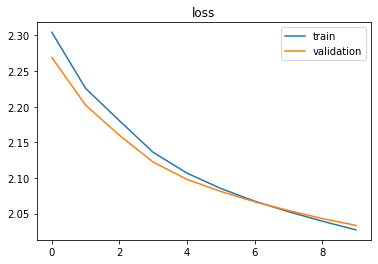

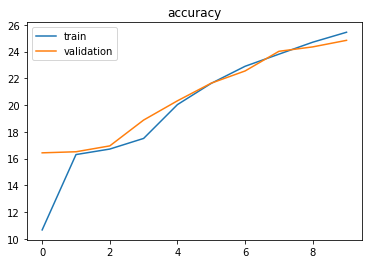

accuracy: 24.759999999999998,recall : 24.759999999999998 ,precision : 22.203846693520934, f1_score : 22.083133797479555, loss_test : 2.034237733370141,
 confusion_matrix :
 [[219  64 228  10   1  66 128  39 164  81]
 [ 65 194  26   6   0  39  91  60 174 345]
 [ 99  12 277  20   2 216 237  60  30  47]
 [ 63  16 100  30   2 371 183 120  29  86]
 [ 84  16 235  18   0 223 268  64  37  55]
 [ 75  12 112  21   1 480 155  80  18  46]
 [ 82  15 102  22   3 241 273 128  27 107]
 [ 66  34 109  28   3 269 161 178  38 114]
 [156 144  62   8   1  76  92  25 320 116]
 [ 44 138  13   7   2  28  81  91  91 505]]  


In [23]:
epochs = 10
batch_size =128
model = MLP()
model.to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
epochs_plots_test (epochs,batch_size,loss_function,optimizer )